In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer
from sentence_transformers import util
import datasets

# Define the list of sentences
sentences = [
    "The marathon runners showed incredible endurance and speed.",
"The author released a new novel that became a bestseller.",
"The chef prepared a gourmet meal that delighted all the guests.",
"Baking pastries requires precision and creativity in the kitchen.",
"Artificial intelligence is shaping the future of technology.",
"The orchestra delivered a breathtaking performance that captivated everyone.",
"Reading fiction books is a great way to relax and unwind.",
"The pianist played a beautiful melody that resonated throughout the hall.",
"He has a passion for landscaping and outdoor design.",
"Environmental conservation efforts are crucial to protect natural habitats.",
"Healthcare professionals are dedicated to improving patient care.",
"Climate change is impacting global weather patterns.",
"The sun sets over the horizon, painting the sky in shades of orange and pink.",
"The advancements in machine learning are transforming how we interact with data.",
"Studying ancient civilizations helps us understand the past."
]

# Load BERT-based model and tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("sbert_test_c")

# Load Sentence Transformer model
sentence_transformer_model = SentenceTransformer('Model_trained')

# Load saved weights for BERT-based model
# bert_model.load_state_dict(torch.load("bert_model_weights.pt"))
bert_model.eval()  # Set to evaluation mode

# Load saved weights for Sentence Transformer model
# sentence_transformer_model.load_state_dict(torch.load("sentence_transformer_model_weights.pt"))
sentence_transformer_model.eval()  # Set to evaluation mode


SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [28]:
# snli = datasets.load_dataset('snli',split="test")
# mnli = datasets.load_dataset("glue","mnli",split="test")
# mnli = mnli.remove_columns(["idx"])
# snli = snli.cast(mnli.features)
# dataset = datasets.concatenate_datasets([snli,mnli])
# all_cols = ['label']
# dataset = dataset.filter(
#     lambda x:False if x['label']==-1 else True
# )

In [29]:
# Function to calculate embeddings using BERT-based model
def get_bert_embeddings(sentences, model, tokenizer):
    wrapped_input = tokenizer(sentences, max_length=15, add_special_tokens=True, truncation=True, 
                              padding='max_length', return_tensors="pt")
    # wrapped_input.to(device)
    encoded_input = {k: v for k, v in wrapped_input.items()}
    output = model(**encoded_input)
    
    # Extract the token embeddings and attention mask from the model output
    token_embeds = output.last_hidden_state
    attention_mask = encoded_input['attention_mask']

    # Apply pooling function
    pooled_output = mean_pool(token_embeds, attention_mask)
    pooled_output = pooled_output.cpu().tolist()  # Convert tensor to list
    return pooled_output

# Function to calculate embeddings using Sentence Transformer model
def get_sentence_transformer_embeddings(sentences, model):
    embeddings = model.encode(sentences, convert_to_tensor=True)
    return embeddings

# Define the mean_pool function
def mean_pool(token_embeds, attention_mask):
    in_mask = attention_mask.unsqueeze(-1).expand(
        token_embeds.size()
    ).float()
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(
        in_mask.sum(1), min=1e-9
    )
    return pool

In [30]:
# Calculate embeddings and sentence embeddings for BERT-based model
bert_embeddings = get_bert_embeddings(sentences, bert_model, bert_tokenizer)

# Calculate embeddings and sentence embeddings for Sentence Transformer model
sentence_transformer_embeddings = get_sentence_transformer_embeddings(sentences, sentence_transformer_model)

# Calculate cosine similarity for BERT-based model
bert_similarity_matrix = cosine_similarity(bert_embeddings, bert_embeddings)

# Calculate cosine similarity for Sentence Transformer model
sentence_transformer_similarity_matrix = cosine_similarity(sentence_transformer_embeddings, sentence_transformer_embeddings)

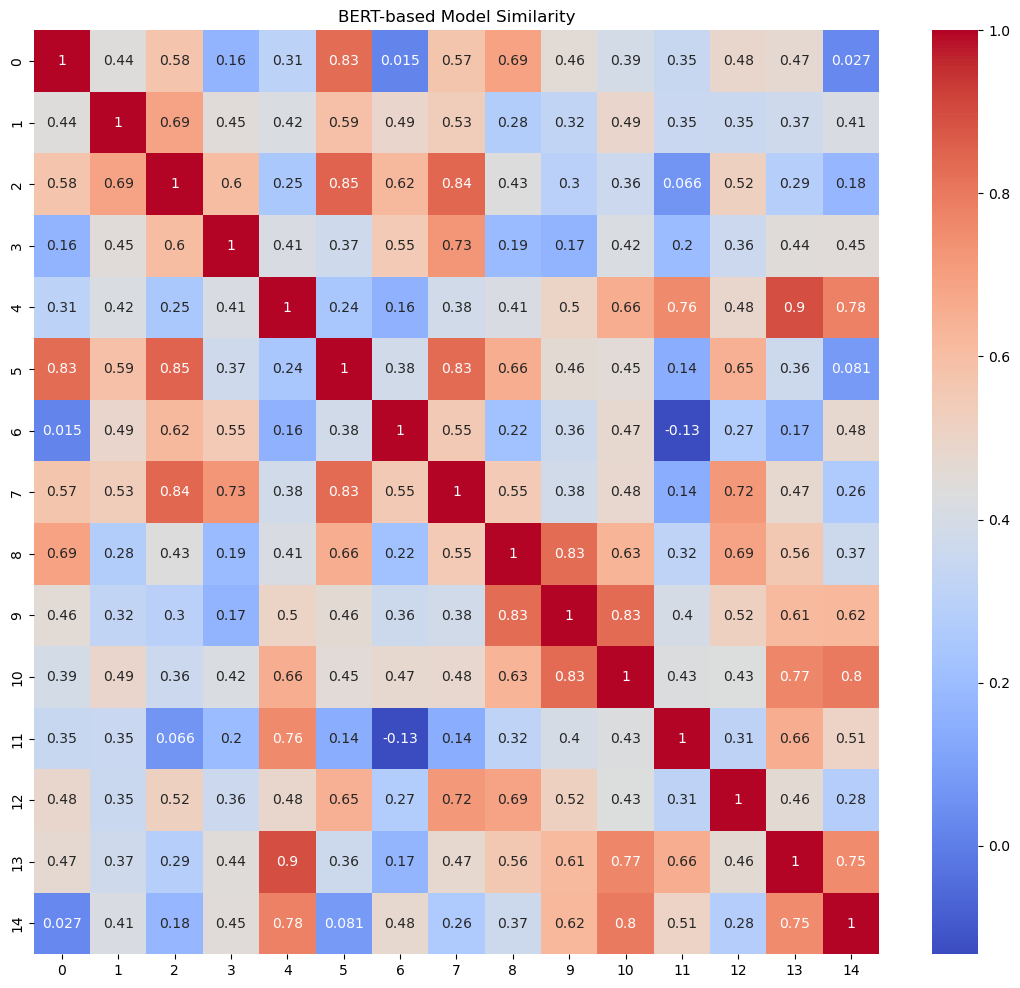

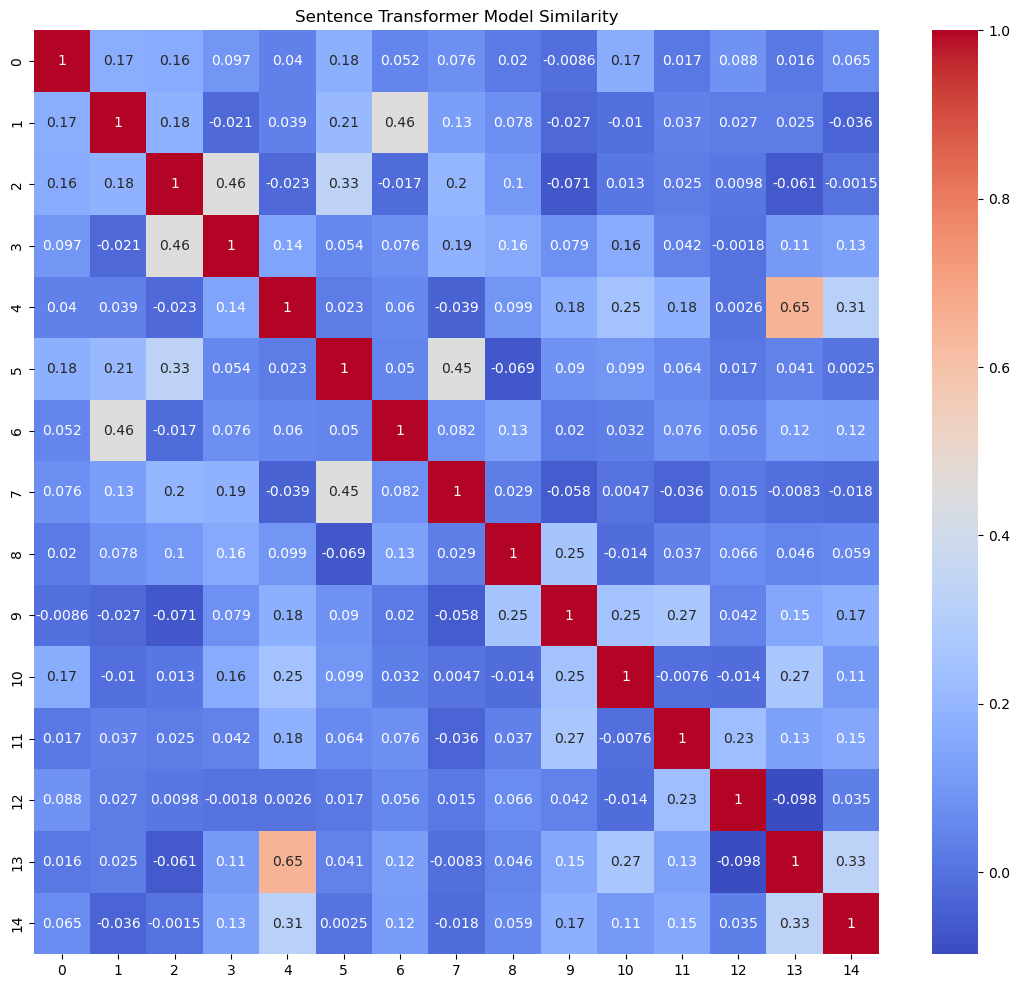

In [32]:
# Create heatmaps for both models
plt.figure(figsize=(30, 12))
plt.subplot(1, 2, 1)
sns.heatmap(bert_similarity_matrix, annot=True, cmap="coolwarm")
plt.title("BERT-based Model Similarity")

plt.figure(figsize=(30, 12))
plt.subplot(1, 2, 2)
sns.heatmap(sentence_transformer_similarity_matrix, annot=True, cmap="coolwarm")
plt.title("Sentence Transformer Model Similarity")

# plt.tight_layout()
plt.show()
